# Pulse sequence evaluation

Using arbitrary units. Energy is normalized to the standard deviation in chemical shift strengths. Reduced Planck's constant $\hbar \equiv 1$.

In [164]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import pandas as pd
import multiprocessing as mp
import importlib

In [2]:
sys.path.append('..')

In [3]:
import pulse_sequences as ps

In [165]:
# importlib.reload(ps)

<module 'pulse_sequences' from '../pulse_sequences.py'>

## Define system

In [169]:
dipolar_strength = 1e1
pulse_width = 1e-4  # time is relative to chemical shift strength
delay = 1e-3
rot_error = 1e-2
N = 4  # number of spins
ensemble_size = 50

In [5]:
X, Y, Z = ps.get_collective_spin(N)

In [170]:
Hsys_ensemble = [ps.get_Hsys(N, dipolar_strength=dipolar_strength) for _ in range(ensemble_size)]
pulses_ensemble = [
    ps.get_pulses(H, X, Y, Z, pulse_width, delay, rot_error=rot_error) for H in Hsys_ensemble
]

In [171]:
Utarget = qt.identity(Hsys_ensemble[0].dims[0])

## Define and evaluate pulse sequences



In [172]:
f = ps.get_mean_fidelity(ps.yxx24 * 2, Utarget, pulses_ensemble)
f, -np.log10(1 - f)

(0.9999936927055427, 5.200156893410582)

In [173]:
f = ps.get_mean_fidelity(ps.yxx48, Utarget, pulses_ensemble)
f, -np.log10(1 - f)

(0.9999953200103507, 5.329755107454664)

In [174]:
f = ps.get_mean_fidelity(ps.mcts12_2 * 4, Utarget, pulses_ensemble)
f, -np.log10(1 - f)

(0.9099014167947017, 1.045282038221367)

In [175]:
f = ps.get_mean_fidelity(ps.mcts12_3 * 4, Utarget, pulses_ensemble)
f, -np.log10(1 - f)

(0.9696329716259133, 1.5175977047521192)

In [176]:
f = ps.get_mean_fidelity(ps.mcts12_4 * 4, Utarget, pulses_ensemble)
f, -np.log10(1 - f)

(0.9690928181794294, 1.509940592981769)

In [177]:
f = ps.get_mean_fidelity(ps.az3, Utarget, pulses_ensemble)
f, -np.log10(1 - f)

(0.9964900567014816, 2.45469989930041)

In [178]:
f = ps.get_mean_fidelity(ps.az12 * 4, Utarget, pulses_ensemble)
f, -np.log10(1 - f)

(0.9411802080782994, 1.23047651616722)

## Evaluate robustness

Looking at several different sources of errors:

- Non-negligible higher-order terms in Magnus expansion
- Rotation errors
- Phase transients
- Offset errors

### Rotation errors

In [179]:
rot_errors = np.linspace(-1, 1, 21)
rot_errors = 1e-1 * rot_errors**2 * np.sign(rot_errors) # non-linear sampling

In [182]:
def f(pulse_sequence, rot_error):
    pe = [ps.get_pulses(H, X, Y, Z, pulse_width, delay, rot_error=rot_error) for H in Hsys_ensemble]
    fidelities = [ps.get_fidelity(pulse_sequence, Utarget, p) for p in pe]
    return np.mean(fidelities), np.std(fidelities)

In [183]:
def get_rot_data(pulse_sequence, rot_errors, num_workers=4):
    with mp.Pool(num_workers) as p:
        output = p.starmap(f, [(pulse_sequence, r) for r in rot_errors])
    
    fidelity, fidelity_std = zip(*output)
    fidelity = np.array(fidelity)
    fidelity_std = np.array(fidelity_std)
    
    return fidelity, fidelity_std

In [184]:
cory48_output = get_rot_data(ps.cory48, rot_errors)

In [191]:
yxx48_output = get_rot_data(ps.yxx48, rot_errors)

In [192]:
yxx24_output = get_rot_data(ps.yxx24 * 2, rot_errors)

In [193]:
az3_output = get_rot_data(ps.az3, rot_errors)

In [194]:
az12_output = get_rot_data(ps.az12 * 4, rot_errors)

In [58]:
# az12_1_output = get_rot_data(ps.az12_1, rot_errors)

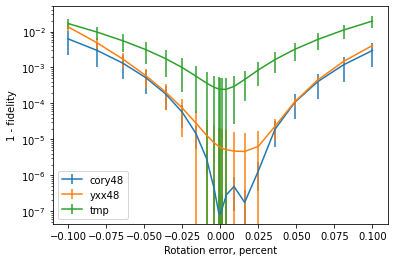

In [209]:
plt.errorbar(rot_errors, 1-cory48_output[0], yerr=cory48_output[1], label='cory48')
plt.errorbar(rot_errors, 1-yxx48_output[0], yerr=yxx48_output[1], label='yxx48')
# plt.errorbar(rot_errors, 1-yxx24_output[0], yerr=yxx24_output[1], label='yxx24')
# plt.errorbar(rot_errors, 1-az3_output[0], yerr=az3_output[1], label='az3')
# plt.errorbar(rot_errors, 1-az12_output[0], yerr=az12_output[1], label='az12')
plt.errorbar(rot_errors, 1-tmp_output[0], yerr=tmp_output[1], label='tmp')
plt.xlabel('Rotation error, percent')
plt.ylabel('1 - fidelity')
plt.yscale('log')
plt.legend()

### Phase transients

In [200]:
phase_transients = 5e-2 * np.linspace(0, 1, 21)**2

In [201]:
def g(pulse_sequence, pt):
    pe = [ps.get_pulses(H, X, Y, Z, pulse_width, delay, phase_transient=pt) for H in Hsys_ensemble]
    fidelities = [ps.get_fidelity(pulse_sequence, Utarget, p) for p in pe]
    return np.mean(fidelities), np.std(fidelities)

In [202]:
def get_pt_data(pulse_sequence, phase_transients, num_workers=4):
    with mp.Pool(num_workers) as p:
        output = p.starmap(g, [(pulse_sequence, r) for r in phase_transients])
    
    fidelity, fidelity_std = zip(*output)
    fidelity = np.array(fidelity)
    fidelity_std = np.array(fidelity_std)
    
    return fidelity, fidelity_std

In [203]:
cory48_pt_output = get_pt_data(ps.cory48, phase_transients)

In [204]:
yxx48_pt_output = get_pt_data(ps.yxx48, phase_transients)

In [205]:
yxx24_pt_output = get_pt_data(ps.yxx24 * 2, phase_transients)

In [149]:
az3_pt_output = get_pt_data(ps.az3, phase_transients)

In [150]:
az12_pt_output = get_pt_data(ps.az12 * 4, phase_transients)

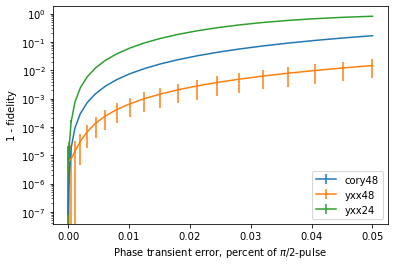

In [207]:
plt.errorbar(phase_transients, 1-cory48_pt_output[0], yerr=cory48_pt_output[1], label='cory48')
plt.errorbar(phase_transients, 1-yxx48_pt_output[0], yerr=yxx48_pt_output[1], label='yxx48')
plt.errorbar(phase_transients, 1-yxx24_pt_output[0], yerr=yxx24_pt_output[1], label='yxx24')
# plt.errorbar(phase_transients, 1-az3_pt_output[0], yerr=az3_pt_output[1], label='az3')
# plt.errorbar(phase_transients, 1-az12_pt_output[0], yerr=az12_pt_output[1], label='az12')
plt.yscale('log')
plt.xlabel(r'Phase transient error, percent of $\pi/2$-pulse')
plt.ylabel('1 - fidelity')
plt.legend()